# Category classification DBPedia using RoBerta

In [ ]:
pip install scikit-learn==0.19.1

     |████████████████████████████████| 9.5 MB 4.1 MB/s 
  ERROR: Failed building wheel for scikit-learn
  Running setup.py clean for scikit-learn
Failed to build scikit-learn
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
    Running setup.py install for scikit-learn ... error
  Rolling back uninstall of scikit-learn
  Moving to /usr/local/lib/python3.7/dist-packages/scikit_learn-0.22.2.post1.dist-info/
   from /usr/local/lib/python3.7/dist-packages/~cikit_learn-0.22.2.post1.dist-info
  Moving to /usr/local/lib/python3.7/dist-packages/sklearn/
   from /usr/local/lib/python3.7/dist-packages/~klearn
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-rpb3z7qa/scikit-learn_be750f3c71654193b9671158179c7047/setup.py'"'"'; __file__='"'"'/tmp/pip-in

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.8 MB 3.9 MB/s 
     |████████████████████████████████| 636 kB 50.7 MB/s 
     |████████████████████████████████| 3.3 MB 33.1 MB/s 
     |████████████████████████████████| 895 kB 55.2 MB/s 
     |████████████████████████████████| 52 kB 1.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
#import transformers
#from transformers import TFRobertaForSequenceClassification, RobertaTokenizer, RobertaConfig

In [ ]:
#read training data (old and new) from SMART Task
url = 'https://raw.githubusercontent.com/smart-task/smart-dataset/master/datasets/DBpedia/smarttask_dbpedia_train.json'

df1 = pd.read_json(url)

url1 = 'https://raw.githubusercontent.com/smart-task/smart-2021-dataset/main/smart2021-AT_Answer_Type_Prediction/dbpedia/task1_dbpedia_train.json'

df2 = pd.read_json(url1)

In [ ]:
#combine old and new data
print(len(df1))
print(len(df2))
df = df1.append(df2)
print(len(df))
#drop duplicates and empty rows or values
df = df.drop_duplicates(subset=['question'])
print(len(df))
#drop rows containing null values
df.dropna()
nan_value = float("NaN")
df.replace("", nan_value, inplace=True)
df.dropna(subset = ["question"], inplace=True)
df = df.reset_index(drop=True)
print(len(df))
df

17571
36670
54241
39509
39508


,id,question,category,type
0,dbpedia_1177,Was Jacqueline Kennedy Onassis a follower of M...,boolean,[boolean]
1,dbpedia_14427,What is the name of the opera based on Twelfth...,resource,"[dbo:Opera, dbo:MusicalWork, dbo:Work]"
2,dbpedia_16615,When did Lena Horne receive the Grammy Award f...,literal,[date]
3,dbpedia_23480,Do Prince Harry and Prince William have the sa...,boolean,[boolean]
4,dbpedia_3681,What is the subsidiary company working for Leo...,resource,"[dbo:EducationalInstitution, dbo:Organisation,..."
...,...,...,...,...
39503,50708,what kinds of music is played by season's end,resource,"[dbo:Genre, dbo:TopicalConcept, dbo:MusicGenre]"
39504,50709,which asteroid group is 6753 fursenko a member...,resource,[dbo:Album]
39505,50710,What language is azhakiya ravanan filmed in?,resource,[dbo:Language]
39506,50712,which position did herby fortunat play in foot...,resource,[dbo:Person]


In [ ]:
df.loc[1]

id                                              dbpedia_14427
question    What is the name of the opera based on Twelfth...
category                                             resource
type                   [dbo:Opera, dbo:MusicalWork, dbo:Work]
Name: 1, dtype: object

In [ ]:
#concatenate to flatten category into 5 types
df.loc[df['category'].map(str) == 'literal', 'cat'] = df['category'].map(str) + df['type'].map(str)
df.loc[df['category'].map(str) != 'literal', 'cat'] = df['category'].map(str)

In [ ]:
#split training and testing data
quest_train, quest_valid = np.split(df['question'], [int(.8*len(df))])
ans_cat_train, ans_cat_valid = np.split(df['cat'], [int(.8*len(df))])
ans_typ_train, ans_typ_valid = np.split(df['type'], [int(.8*len(df))])

In [ ]:
print(quest_train.shape,
quest_valid.shape)

(31905,) (7977,)


In [ ]:
#load pretrained Roberta models

bert = TFRobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=5)

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/657M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
#preprocessing
question = df['question'].astype(str).values.tolist()

category = df['cat'].values.tolist()

In [ ]:
#preprocessing - tokenize, add CLS, SEP and PAD
input_ids=[]
attention_masks=[]

bert_inp = tokenizer.batch_encode_plus(question, add_special_tokens=True, max_length=64, padding=True, return_attention_mask = True)

input_ids.append(bert_inp['input_ids'])
attention_masks.append(bert_inp['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels=np.array(category)

In [ ]:
#decoder
tokenizer.decode(bert_inp['input_ids'][1])

'<s>What is the name of the opera based on Twelfth Night?</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'

In [ ]:
#one hot encoding
from numpy import array
from numpy import argmax
from tensorflow.keras.utils import to_categorical
# define example
data = array(category)
convert_data = []
# manual change values to integer
for d in data:
    if d == "resource":
        convert_data.append(0)
    elif d == "literal['number']":
        convert_data.append(1)
    elif d == "literal['string']":
        convert_data.append(2)
    elif d == "literal['date']":
        convert_data.append(3)        
    else:
        convert_data.append(4)
print(convert_data)
# one hot encode
encoded = to_categorical(convert_data)
print(encoded)
# invert encoding
inverted = argmax(encoded[0])
print(inverted)

[4, 0, 3, 4, 0, 2, 0, 4, 2, 0, 1, 0, 0, 4, 0, 0, 0, 0, 3, 0, 0, 4, 3, 0, 0, 0, 0, 3, 0, 3, 1, 0, 4, 1, 0, 0, 4, 0, 0, 0, 0, 2, 0, 3, 4, 3, 1, 0, 3, 0, 0, 1, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 4, 1, 0, 3, 3, 2, 0, 0, 1, 0, 2, 0, 0, 0, 4, 3, 0, 4, 4, 4, 0, 4, 0, 0, 2, 0, 0, 4, 0, 0, 2, 0, 3, 0, 4, 0, 2, 0, 0, 0, 0, 0, 0, 4, 0, 4, 3, 3, 1, 2, 0, 3, 4, 1, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 3, 2, 1, 0, 4, 1, 1, 0, 0, 0, 0, 0, 3, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 1, 0, 4, 0, 3, 0, 1, 2, 0, 0, 4, 1, 0, 0, 4, 0, 0, 1, 3, 1, 0, 0, 0, 4, 0, 0, 3, 2, 3, 0, 0, 4, 0, 3, 0, 4, 2, 0, 0, 0, 0, 1, 0, 0, 4, 1, 4, 4, 0, 0, 0, 0, 3, 4, 3, 1, 3, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 1, 3, 0, 0, 0, 0, 4, 0, 0, 0, 1, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 4, 0, 0, 1, 0, 0, 0, 3, 0, 4, 0, 4, 0, 0, 0, 3, 4, 0, 2, 4, 2, 2, 4, 0, 0, 2, 4, 2, 1, 4, 4, 1, 3, 4, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 4, 0, 0, 0, 2, 0, 0, 1, 0, 2, 0, 4, 3, 0, 2, 0, 3, 0, 0, 0, 0, 0, 1, 4, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 

In [ ]:
label = np.array(convert_data)
print(label.shape)
print(labels.shape)
input_ids = np.array(tf.squeeze(input_ids))
attention_masks = np.array(tf.squeeze(attention_masks))
print(input_ids.shape)
print(attention_masks.shape)

(39882,)
(39882,)
(39882, 186)
(39882, 186)


In [ ]:
#load data into a file
#test and train data split
train_inp,val_inp,train_label,val_label,train_mask,val_mask=train_test_split(input_ids,label,attention_masks,test_size=0.2)

print('Train inp shape {} Val input shape {}\nTrain label shape {} Val label shape {}\nTrain attention mask shape {} Val attention mask shape {}'.format(train_inp.shape,val_inp.shape,train_label.shape,val_label.shape,train_mask.shape,val_mask.shape))

Train inp shape (31905, 186) Val input shape (7977, 186)
Train label shape (31905,) Val label shape (7977,)
Train attention mask shape (31905, 186) Val attention mask shape (7977, 186)


In [ ]:
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint

model_save_path='dbpedia_category_bert.h5'

callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath= model_save_path,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True)]

print('\nBert Model',bert.summary())

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

bert.compile(loss=loss,optimizer=optimizer,metrics=[metric])

Model: "tf_roberta_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
roberta (TFRobertaMainLayer) multiple                  124055040 
_________________________________________________________________
classifier (TFRobertaClassif multiple                  594437    
Total params: 124,649,477
Trainable params: 124,649,477
Non-trainable params: 0
_________________________________________________________________

Bert Model None


In [ ]:
print(train_inp.shape)
print(train_mask.shape)
print(train_label.shape)
print(val_inp.shape)
print(val_mask.shape)
print(val_label.shape)

(31905, 186)
(31905, 186)
(31905,)
(7977, 186)
(7977, 186)
(7977,)


In [ ]:
history=bert.fit([train_inp,train_mask],train_label,batch_size=32,epochs=4,validation_data=([val_inp,val_mask],val_label),callbacks=callbacks)

Epoch 1/4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autogr

In [ ]:
#save model
bert.save('saved_model/dbpedia_model')

INFO:tensorflow:Assets written to: saved_model/dbpedia_model/assets


INFO:tensorflow:Assets written to: saved_model/dbpedia_model/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
#@title `plot_history()` definition
from matplotlib import pyplot as plt

def plot_history(history, ylim=None):
  fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, dpi=150)
  epochs = np.array(history.epoch)+1
  ax1.plot(epochs, history.history['loss'], 
           label='training')
  if history.history.__contains__('val_loss'):
    ax1.plot(epochs, history.history['val_loss'], 
             label='validation')
  if history.history.__contains__('lr'):
    ax1b = ax1.twinx()
    ax1b.plot(epochs, history.history['lr'], 
              'g-', linewidth=1)
    ax1b.set_yscale('log')
    ax1b.set_ylabel('Learning Rate', color='g')

  ax1.set_ylabel('Cross-Entropy Loss')
  ax1.set_yscale('log')
  ax1.grid(alpha=.5)

  ax2.plot(epochs, history.history['accuracy'], 
           label='training')
  if history.history.__contains__('val_accuracy'):
    ax2.plot(epochs, history.history['val_accuracy'], 
             label='validation')
    ax2.legend()
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.grid(alpha=.5)
  if ylim:
    ax2.set_ylim(ylim)
  
  plt.show() 

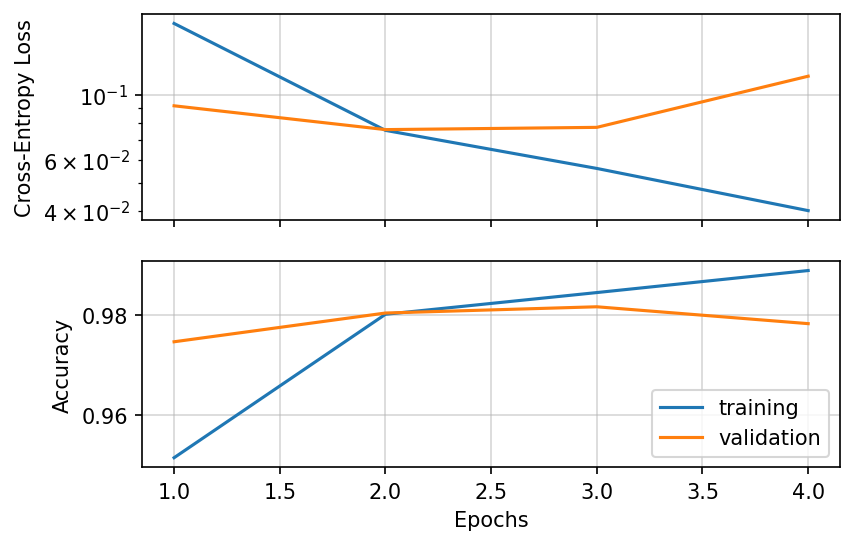

In [ ]:
plot_history(history)

In [ ]:
val_predict = bert.predict([val_inp,val_mask])

In [ ]:
val_predict = np.argmax(val_predict.logits, axis=-1)

In [ ]:
from sklearn.metrics import classification_report
print('      DBPedia Training Dataset - Category Classification')
print()
print(classification_report(val_label,val_predict,target_names=['resource', 'literal-number', 'literal-string','literal-date','boolean']))

      DBPedia Training Dataset - Category Classification

                precision    recall  f1-score   support

      resource       0.98      1.00      0.99      6419
literal-number       0.97      0.86      0.91       298
literal-string       0.98      0.85      0.91       409
  literal-date       0.98      0.88      0.93       340
       boolean       0.98      0.98      0.98       511

      accuracy                           0.98      7977
     macro avg       0.98      0.91      0.94      7977
  weighted avg       0.98      0.98      0.98      7977

